# Problem Statement
The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

**Goal: predict the labels on the test dataset, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist** 

### Reference resources: 
I made reference to the following contents found on the internet, they're super helpful to me to complete this final project and I truly appreciate all those author/people for all helpful instruction and well-written topic 

#### https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
#### https://github.com/makcedward/nlp/blob/master/sample/nlp-bag_of_words.ipynb
#### https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90
#### https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27
#### https://medium.com/vickdata/detecting-hate-speech-in-tweets-natural-language-processing-in-python-for-beginners-4e591952223

## 1/ Import libraries & take overview about dataset

### 1.1 import libraries and take a look at dataset

In [39]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from collections import Counter
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style("whitegrid")
%matplotlib inline

In [40]:
tweets_train = pd.read_csv('./data/train_E6oV3lV.csv', encoding='latin-1')
tweets_test = pd.read_csv('./data/test_tweets_anuFYb8.csv', encoding='latin-1')

In [41]:
tweets_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [91]:
tweets_train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

we have 2,242 (~7%) tweets labeled as racist or sexist, and 29,720 (~93%) tweets labeled as non racist/sexist

In [42]:
tweets_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [43]:
# Let take a look at how are hate tweet   
tweets_train.shape, tweets_test.shape

((31962, 3), (17197, 2))

### 1.2 Combine 2 datasets into one for easier processing 

In [44]:
data = tweets_train.append(tweets_test, ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49159 entries, 0 to 49158
Data columns (total 3 columns):
id       49159 non-null int64
label    31962 non-null float64
tweet    49159 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB


/home/ander/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## 2/ Data preprocessing

In [45]:
data.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation


### 2.1 Remove @user or all words starting with ‘@’.**

**We can see lots of tweets have meantioning text @user that not make sense to evaluate sentiment, so we will remove it from tweets. Moreover, we need to also remove all tose kind of mentioning words starting with ‘@’**
#### Firstly, we define a function to use later

In [46]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

**Apply function to remove @user , @...**

In [47]:
data['clean_tweet'] = np.vectorize(remove_pattern)(data['tweet'], "@[\w]*")

In [48]:
data.head()

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


### 2.2 HTML decoding

In [49]:
# Take a look at a line
data.clean_tweet[1978]

"#bb18 is gonna suck sweaty balls this summer, tg for #bbuk good cast 2 houses secret tasks...grodner &amp; kass don't think outside the box  "

It looks like HTML encoding has not been converted to text, and ended up in text field as ‘&amp’,’&quot’,etc. 
We will use **BeautifulSoup** for decoding HTML to general text

In [50]:
from bs4 import BeautifulSoup
data['clean_tweet'] = [BeautifulSoup(text, 'lxml').get_text() for text in data['clean_tweet']]

In [51]:
# check that line again to see if our code above take effect
data.clean_tweet[1978]

"#bb18 is gonna suck sweaty balls this summer, tg for #bbuk good cast 2 houses secret tasks...grodner & kass don't think outside the box  "

### 2.3 Removing Punctuations, Numbers, and Special Characters
We also want to remove punctuations, numbers and even special characters since they wouldn’t help in bulding our analysis prediction

In [52]:
data['clean_tweet'] = data['clean_tweet'].str.replace("[^a-zA-Z#]", " ")

In [53]:
data.head()

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause they...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


### 2.4 Remove stopwords
The most common words are meaningless in terms of sentiment: I, to, the, and... they don't give any information on positiveness or negativeness. 
They're basically noise that can most probably be eliminated. 
It is recommended that we remove them when doing text analysis.

In [54]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def stopwords_processing(text):
    # Tokenize
    tokens = text.split(' ')
    # Lower case
    tokens = [w.lower() for w in tokens]
    # Remove stop words
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /home/ander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
data['clean_tweet'] = np.vectorize(stopwords_processing)(data['clean_tweet'])

### 2.5 Tokenization
Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [56]:
tokenized_tweet = data['clean_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [father, dysfunctional, selfish, drags, kids, ...
1    [thanks, #lyft, credit, use, cause, offer, whe...
2                                    [bihday, majesty]
3                 [#model, love, u, take, u, time, ur]
4                   [factsguide, society, #motivation]
Name: clean_tweet, dtype: object

In [57]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [father, dysfunct, selfish, drag, kid, dysfunc...
1    [thank, #lyft, credit, use, caus, offer, wheel...
2                                    [bihday, majesti]
3                 [#model, love, u, take, u, time, ur]
4                         [factsguid, societi, #motiv]
Name: clean_tweet, dtype: object

In [58]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

data['clean_tweet'] = tokenized_tweet

In [59]:
data.head()

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunct #run
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit use caus offer wheelchair v...
2,3,0.0,bihday your majesty,bihday majesti
3,4,0.0,#model i love u take with u all the time in ...,#model love u take u time ur
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


## 3/ Word map & hashtags analysis for negative  tweets  (in our work they're called Racist/Sexist Tweets)

### 3.1 Racist/Sexist Tweets

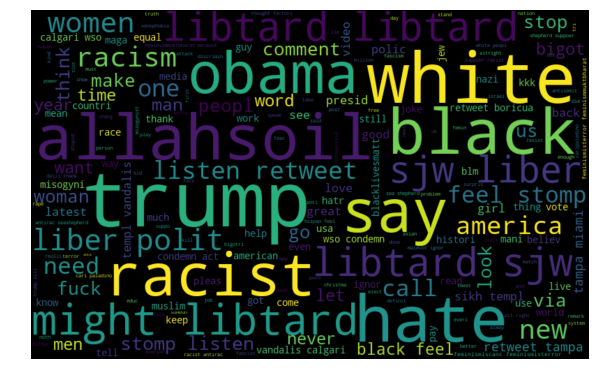

In [60]:
from wordcloud import WordCloud
negative_words = ' '.join([text for text in data['clean_tweet'][data['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will the hashtags/trends in our twitter data.

### 3.2 Impact of Hashtags on tweets sentiment - should we remove hashtags?

In [61]:
# let define a function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [62]:
# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(data['clean_tweet'][data['label'] == 1])
HT_negative = sum(HT_negative,[])

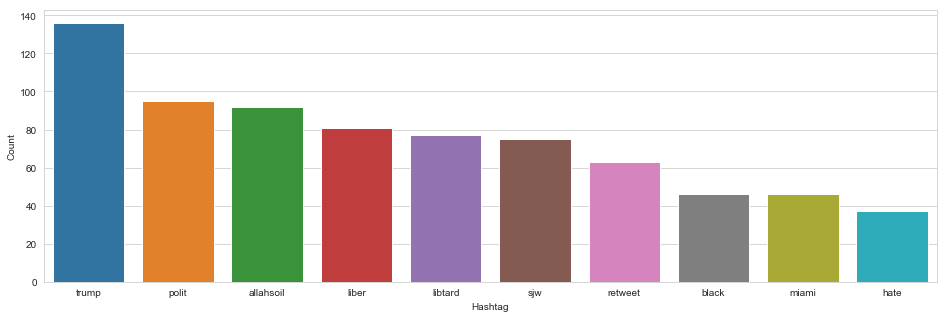

In [63]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

So we can see most of hashtags make sense and contribute to the sentiment of tweet. Hence, we should keep these hashtags in our data as they contain useful information.

## 4/  Extracting Features from Cleaned Tweets & Bulding Models

### 4.1 Import libraries & Prepare functions

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def build_model(mode, classifier):
    # Intent to use default paramaters for show case
    vect = None
    if mode == 'bag_of_words':
        vect = CountVectorizer()
        print(vect)
    elif mode == 'tfidf':
        vect = TfidfVectorizer()
    else:
        raise ValueError('Mode should be either count or tfidf')
        
    if classifier == 'logistic_regression': 
        clf = LogisticRegression(solver='newton-cg',random_state=101, n_jobs=-1)
    elif classifier == 'random_forest':
        clf = RandomForestClassifier(n_estimators=100, random_state=101)
    elif classifier == 'support_vector_machine':
        clf = svm.SVC(kernel='linear', C=1, probability=True)
    
    return Pipeline([
        ('vect', vect),
        ('clf' , clf)
    ])

def pipeline(x, y, mode, classifier):
    model_pipeline = build_model(mode, classifier)
    cv = KFold(n_splits=5, shuffle=True)
    
    scores = cross_val_score(model_pipeline, x, y, cv=cv, scoring='f1')
    print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    return model_pipeline

### 4.2 Select train dataset & prepare test set

In [65]:
data

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunct #run
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit use caus offer wheelchair v...
2,3,0.0,bihday your majesty,bihday majesti
3,4,0.0,#model i love u take with u all the time in ...,#model love u take u time ur
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv
5,6,0.0,[2/2] huge fan fare and big talking before the...,huge fan fare big talk leav chao pay disput ge...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camp tomorrow danni
7,8,0.0,the next school year is the year for exams.Ã°Â...,next school year year exam think #school #exam...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,love land #allin #cav #champion #cleveland #cl...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcom #gr


Our train dataset include rows having known label 0/1, all rows having label "NaN" are unseen data and be extracted into our test set for final prediction later on

In [66]:
print(tweets_train.shape[0], sep="\n")

31962


In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_train = data[:31962]['clean_tweet']
y_train = data[:31962]['label']
test_final = data[31962:]['clean_tweet']


### 4.3 Applying model + Cross-validation on each model performance

#### Logistic Regression


In [69]:
print('------ Bag of Words + Logistic Regression ------')
model_lr_bow = pipeline(X_train, y_train, mode='bag_of_words', classifier='logistic_regression')

print('------ TFIDF + Logistic Regression------')
model_lr_tfidf = pipeline(X_train, y_train, mode='tfidf', classifier='logistic_regression')

------ Bag of Words + Logistic Regression ------
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
F1-score: 0.65 (+/- 0.03)
------ TFIDF + Logistic Regression------
F1-score: 0.47 (+/- 0.03)


#### Random Forest

In [70]:
print('------ Bag of Words + Random Forest ------')
model_rf_bow = pipeline(X_train, y_train, mode='bag_of_words', classifier='random_forest')

print('------ TF-IDF + Random Forest ------')
model_rf_tfidf = pipeline(X_train, y_train, mode='tfidf', classifier='random_forest')

------ Bag of Words + Random Forest ------
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
F1-score: 0.68 (+/- 0.03)
------ TF-IDF + Random Forest ------
F1-score: 0.68 (+/- 0.03)


#### Support Vector Machine

In [71]:
print('------ Bag of Words + Support Vector Machine ------')
model_svm_bow = pipeline(X_train, y_train, mode='bag_of_words', classifier='support_vector_machine')

print('------ TF-IDF + Support Vector Machine ------')
model_svm_tfidf = pipeline(X_train, y_train, mode='tfidf', classifier='support_vector_machine')

------ Bag of Words + Support Vector Machine ------
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
F1-score: 0.69 (+/- 0.06)
------ TF-IDF + Support Vector Machine ------
F1-score: 0.67 (+/- 0.04)


**My evaluation:  it seems the Support Vector Machine model results in highest f1-score, but its performance is not ideal at all (quite slow on my machine). Random Forest has a good balance of hight f1-score + performance. By the way, our choice will be Support Vector Machine + Bag of Words feature to aim the most prefered f1-score**

### 4.4 Training model

In [76]:
from sklearn.metrics import f1_score
model_final = build_model(mode='bag_of_words', classifier='support_vector_machine')
model_final.fit(X_train, y_train)
print('Number of Vocabulary: %d'% (len(model_final.named_steps['vect'].get_feature_names())))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
Number of Vocabulary: 31615


## 5/ Using preferred model to make prediction on test set and output result to csv file

In [93]:
prediction = model_final.predict(test_final)
prediction_int = prediction.astype(np.int)
tweets_test['label'] = prediction_int
submission = tweets_test[['id', 'label']]
submission.to_csv('Duc_20-04-2019.csv', index=False)
submission["label"].value_counts()

0    16140
1     1057
Name: label, dtype: int64

we have 1057 (~6.5%) tweets are predicted as racist or sexist, our model seems to be as expected

# THE END. 
## Thanks for your attention!